# Preparing Data 4 the AE

### Import and function definition

In [ ]:
import sys, os

In [ ]:
import pandas as pd
import polars as pl
import numpy as np
import timeit, math, copy, yaml, ast, subprocess, json
from omsapi import OMSAPI
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.optimize import curve_fit

from drawing_utilities import *
from rebinning import in_out_sel, normalize_2, station3_boundaries, rebin, make_rebin_regions

%load_ext memory_profiler

### Read data and add lumi info

In [3]:
out_label = "test"
me = "hRHGlobalm2"
path = "./MEs/"
dirs = os.listdir(path)
me_dirs = [path+i for i in dirs if me in i and os.path.isdir(path+i)]
print(me_dirs)

['./MEs/hRHGlobalm2I', './MEs/hRHGlobalm2F', './MEs/hRHGlobalm2G', './MEs/hRHGlobalm2E', './MEs/hRHGlobalm2H', './MEs/hRHGlobalm2D']


In [4]:
files_all = []
for dir in me_dirs:
    files = os.listdir(dir)
    me_files = [dir+"/"+i for i in files if me in i]
    files_all = files_all + me_files
filtered_files = [file for file in files_all if os.path.exists(file) and os.path.getsize(file) >= 601]

In [5]:
%%time
# This is less time-efficent than
# monitoring_elements = pd.read_parquet(filtered_files)
# but it's more memory-efficent
# peak memory: 34GiB instead of 60GiB
monitoring_elements = pd.DataFrame()
for file in filtered_files:
    df = pd.read_parquet(file)
    df = df[df['dataset'].str.contains("StreamExpress")]
    monitoring_elements = pd.concat([monitoring_elements, df], ignore_index=True)
    del df

CPU times: user 1min 10s, sys: 22.9 s, total: 1min 32s
Wall time: 1min 53s


In [6]:
dataset = monitoring_elements["dataset"].unique()
print(dataset)

['/StreamExpress/Run2024I-Express-v1/DQMIO'
 '/StreamExpress/Run2024I-Express-v2/DQMIO'
 '/StreamExpress/Run2024F-Express-v1/DQMIO'
 '/StreamExpress/Run2024G-Express-v1/DQMIO'
 '/StreamExpress/Run2024E-Express-v1/DQMIO'
 '/StreamExpress/Run2024H-Express-v1/DQMIO'
 '/StreamExpress/Run2024D-Express-v1/DQMIO']


In [7]:
run_list = np.sort(np.unique(monitoring_elements["run_number"].unique()))

In [13]:
%%time
command = f"conda run --prefix /lustrehome/mbuonsante/miniconda3/envs/oms python3 getInfo.py '{json.dumps(run_list.tolist())}' perLSinfo.parquet"
subprocess.run(command, text=True, shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL);

CPU times: user 5.81 ms, sys: 362 ms, total: 368 ms
Wall time: 1min 33s


In [14]:
lumi_info = pd.read_parquet("perLSinfo.parquet")

In [10]:
%%time
%memit monitoring_elements = pd.merge(monitoring_elements, lumi_info, on=['run_number', 'ls_number'], how='left') 

peak memory: 17803.58 MiB, increment: 126.22 MiB
CPU times: user 159 ms, sys: 137 ms, total: 296 ms
Wall time: 466 ms


In [11]:
%%time
monitoring_elements = monitoring_elements[
    (monitoring_elements["beams_stable"] == True) &
    (monitoring_elements["cscm_ready"] == True) &
    (monitoring_elements["cms_active"] == True) &
    (monitoring_elements["beam_present"] == True) &
    (monitoring_elements["physics_flag"] == True) &
    (monitoring_elements["cscSTANDBY"] == 0) &
    (monitoring_elements["cscBAD"] == 0) &
    (monitoring_elements["cscGOOD"] != 0) &
    (monitoring_elements["mean_lumi"] > 2) &
    (monitoring_elements["class"].str.contains("Collisions", na=False))
]

CPU times: user 76.3 ms, sys: 53 µs, total: 76.4 ms
Wall time: 101 ms


In [12]:
monitoring_elements = monitoring_elements.sort_values(by=['run_number', 'ls_number']).reset_index()
monitoring_elements = monitoring_elements.drop(columns=["index"])

In [13]:
def groupbylumi(df, lumimax):
    lumisum = 0
    groupID = 0
    groups = []

    for lumi in df["mean_lumi"]:
        lumisum += lumi
        groups.append(groupID)

        if lumisum > lumimax:
            lumisum = 0
            groupID += 1

    return groups

def sum_imgs(group):
    return pd.Series({
        "lumi": group["mean_lumi"].sum(),
        "entries": group["entries"].sum(),
        "run_min": group["run_number"].iloc[0],
        "run_max": group["run_number"].iloc[-1],
        "ls_min": group["ls_number"].iloc[0],
        "ls_max": group["ls_number"].iloc[-1],
        "img": np.sum(group["data"], axis=0),
    })

In [14]:
monitoring_elements["group"] = groupbylumi(monitoring_elements, 300)

In [15]:
%%time
%memit summed_data = monitoring_elements.groupby("group").apply(sum_imgs, include_groups=False).reset_index()

peak memory: 18403.25 MiB, increment: 540.47 MiB
CPU times: user 14.7 s, sys: 1.54 s, total: 16.3 s
Wall time: 16.6 s


In [18]:
%%time
%memit summed_data["img"] = summed_data["img"].apply(lambda histo: np.vstack(histo).astype(np.float32))

peak memory: 18675.93 MiB, increment: 276.08 MiB
CPU times: user 1.1 s, sys: 288 ms, total: 1.38 s
Wall time: 1.66 s


In [16]:
mean_matrix = np.mean(summed_data["img"], axis=0)

In [17]:
%%time
inner_radius, outer_radius = station3_boundaries()
regions = make_rebin_regions(mean_matrix, inner_radius, outer_radius, 5, 1) 
%memit summed_data["new_img_in"], summed_data["new_img_out"], summed_data["entries_norm"] = zip(*summed_data.apply(lambda row: normalize_2(row, regions), axis=1))


peak memory: 18716.93 MiB, increment: 32.82 MiB
CPU times: user 7.97 s, sys: 433 ms, total: 8.4 s
Wall time: 8.78 s


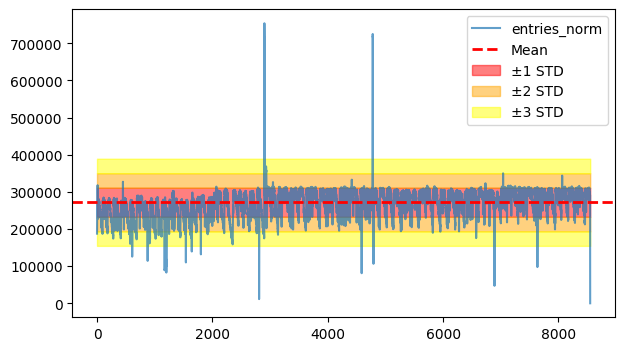

In [19]:
entry_plot(summed_data["entries_norm"])

In [18]:
mean_entries_norm = summed_data["entries_norm"].mean()
std_entries_norm = summed_data["entries_norm"].std()
summed_data["bad_flag"] = summed_data["entries_norm"].apply(
    lambda e: 1 if abs(e - mean_entries_norm) < 4 * std_entries_norm else 0
)

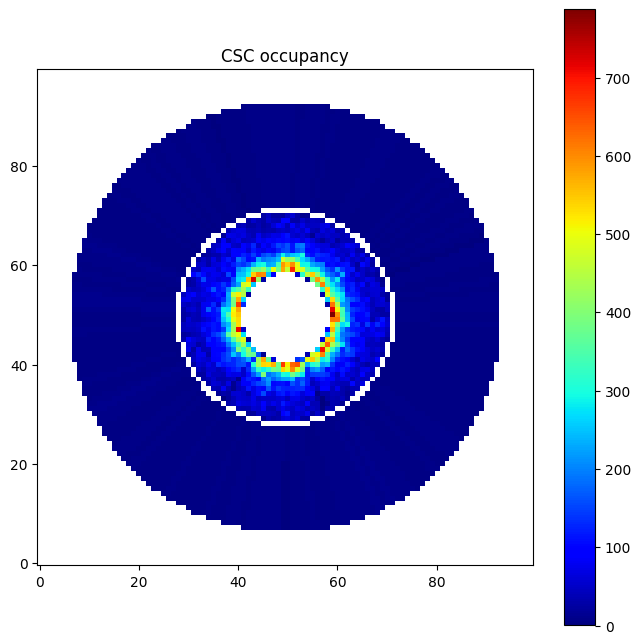

In [20]:
Show2Dimg(summed_data["new_img_in"][0]+summed_data["new_img_out"][0])

In [27]:
summed_data["bad_flag"] = 1
np.savez(me+'_'+out_label+'_s1.npz', imgs_in=summed_data["new_img_in"], imgs_out=summed_data["new_img_out"], imgs=summed_data["img"], lumis=summed_data["lumi"], entry=summed_data["entries_norm"], run_min=summed_data["run_min"], run_max=summed_data["run_max"], lumi_min=summed_data["ls_min"], lumi_max=summed_data["ls_max"], bad_flag=summed_data["bad_flag"])